# Sequential approach (SA) for modeling TRM dynamics

In the first part of the paper, we use a more traditional approach in which we first cluster the data, and then fit models to resulting timeseries. One issue with unsupervised clustering of TRM flow data is that e.g. Leiden cluster outcomes are highly dependent on the random number generator seed. We try to account for this by repeating the clustering 20 times, and then derive a consensus clustering to generate the timeseries. This requires some manual labor.

### Steps / Pipeline

* Repeat Leiden clustering for a range of random seeds **(this notebook)**
* Try to find "robust / consensus" clusters **(this notebook)**
* Fit Stan models to the consensus cluster timeseries.
* Model comparison with LOO-IC

### Difficulties / Challenges

* The multiple cluster runs are done on a HPC cluster with slurm. Repeating this depends on your setup. It should not be to difficult to do this locally, but you'll have to ba patient.
* We use Leiden clustering to define T cell clusters for the Lung T cell data. We use a intensity parameter such that we slightly over-lister the data. We then manually annotate different clusters into cell types. We do this separetely for 20 different Leiden runs (with different seeds), and use the same cell types. This allows us to say for each cell, how many times it was assigned to each of the cell types. Doing this is time-consuming and means that the method is no longer 100% unsupervised.
* The Leiden cluster runs have a very low probability of reproducability. It's not completely clear why this is the case. Perhaps `scanpy` version mismatches? We have included 20 Leiden cluster runs to create the figures. If you repeat this analysis, you **should** get very similar results, but you would have to manually re-annotate the clusters.

In [1]:
import scanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.stats as sts
from collections import Counter
from tqdm.notebook import trange
import json
import sys
import pickle
import os
from matplotlib.gridspec import GridSpec

import scdynsys.plots as plots
import scdynsys.utilities as utils
import scdynsys.clus
    
# define colors for clsuters / celltypes

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

## Import data using `pandas`

import cell counts and flow cytometry data

In [2]:
with open(f"../data/CD8_counts_Aug23.pkl", 'rb') as f:
    cell_counts = pickle.load(f)

data = pd.read_hdf(f"../data/flow_data_Lung_CD8_ivneg_agexp.hdf5")
display(data)

fields = list(data.columns)
# include markers up to CD11a (exclude scatter, dump, etc)
markers = fields[:fields.index("CD11a")+1]
## annotations (mouse ID, day, ...)
ann = fields[fields.index("sample"):] 

display(" ".join(ann))
display(" ".join(markers))

## map the mouse ID to the DPI

day_dict = dict(zip([str(x) for x in data.mouse], data.dpi))

,CD8_NP,CD4,CX3CR1,Bcl2,CD3,FR4,CD103,CD49a,CD8,CD45.2_IV,...,SSC-B-A,SSC-B-H,SSC-H,AF-A,dump,L_D,Time,sample,mouse,dpi
0,-0.022835,-0.370316,0.470357,0.936386,1.349341,0.584966,2.064353,2.063588,2.184199,-0.101171,...,340704.937500,265697.0,629560.0,5064.385742,7585.715507,2247.627230,0.0006,M24_Lung_d20_03AUG2023_CD3_Protected,24,20
1,-0.136115,0.111916,0.380389,0.463707,2.394131,-0.308722,2.910066,2.245524,1.438918,0.046482,...,420340.687500,344566.0,931342.0,5009.141113,3499.582990,-444.517928,0.0014,M24_Lung_d20_03AUG2023_CD3_Protected,24,20
2,0.151578,0.151473,-0.208985,0.370265,1.763606,0.117972,1.891425,2.447777,1.986507,0.655401,...,162986.593750,116031.0,352923.0,4677.554199,9879.017918,846.049156,0.0235,M24_Lung_d20_03AUG2023_CD3_Protected,24,20
3,0.053295,-0.025187,0.286631,0.532109,1.294737,0.150636,0.026941,1.433403,2.187047,0.239337,...,190911.625000,144715.0,388191.0,6165.231445,10359.627296,-1050.183058,0.0235,M24_Lung_d20_03AUG2023_CD3_Protected,24,20
4,3.507220,-0.114078,0.569518,0.337305,1.240402,0.297239,2.396671,3.001063,1.666983,0.042112,...,279249.875000,229176.0,553892.0,4354.082520,4650.208626,-4122.965000,0.0299,M24_Lung_d20_03AUG2023_CD3_Protected,24,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959985,-0.252656,0.001038,-0.015589,1.914663,2.198471,0.155197,3.863888,2.265008,2.194387,0.001215,...,317907.093750,233997.0,631159.0,7747.333984,6083.743704,-2200.100769,112.5982,M42_Lung_d55_03AUG2023_CD3_Protected,42,57
959986,-0.386188,-0.387821,0.300880,2.499079,1.666465,0.924377,2.520479,2.126640,2.829895,-0.163409,...,480600.781250,376341.0,886313.0,6849.693359,4273.480732,211.271655,112.6026,M42_Lung_d55_03AUG2023_CD3_Protected,42,57
959987,4.018635,-0.029064,-0.094428,1.218590,1.261820,0.035663,0.510888,0.930495,1.701761,0.087711,...,234424.515625,181268.0,597837.0,6886.500000,6950.415412,-1991.278482,112.6158,M42_Lung_d55_03AUG2023_CD3_Protected,42,57
959988,-0.480210,-0.185664,0.312117,2.367973,0.993285,0.395869,1.047499,2.092746,3.174983,0.360408,...,318661.437500,259987.0,633338.0,5733.781738,4735.488373,-684.560722,112.6652,M42_Lung_d55_03AUG2023_CD3_Protected,42,57


'sample mouse dpi'

'CD8_NP CD4 CX3CR1 Bcl2 CD3 FR4 CD103 CD49a CD8 CD45.2_IV CD62L CD27 CXCR5 CXCR6 CD44 CD4_NP CD69 Ki67 PD1 Klrg1 FOXP3 CD11a'

## import in `scanpy`

* add mouse and DPI
* scale the data
* select a subset of the markers

In [3]:
labels = list(data.index)

ann_data = scanpy.AnnData(data[markers].to_numpy())

ann_data.var_names = markers
ann_data.obs_names = [str(x) for x in labels]

## add metadata

ann_data.obs["mouse"] = [str(x) for x in data["mouse"]]
ann_data.obs["dpi"] = [x for x in data["dpi"]]
mice = sorted(set([str(x) for x in data["mouse"]]), key=lambda x: int(x))

display(ann_data)

## scale the flow data

scanpy.pp.scale(ann_data)

## select only relevant markers

print("all markers:", " ".join(markers))

## CD8 markers
sel_markers = [
    'CD49a', 
    'CD103', 
    'CD69',
    'CXCR6',
    'PD1', 
    'Klrg1',
    'CD62L',
    'Bcl2',
    'CX3CR1',
    'CD27',    
]

## for some applications, we may want to add Ki67 and tetramer staining
sel_markers_ext = sel_markers + ["Ki67", "CD8_NP"]

ann_data.obsm["X_selected"] = ann_data[:,sel_markers].X
ann_data.obsm["X_selected_ext"] = ann_data[:,sel_markers_ext].X

AnnData object with n_obs × n_vars = 959990 × 22
    obs: 'mouse', 'dpi'

all markers: CD8_NP CD4 CX3CR1 Bcl2 CD3 FR4 CD103 CD49a CD8 CD45.2_IV CD62L CD27 CXCR5 CXCR6 CD44 CD4_NP CD69 Ki67 PD1 Klrg1 FOXP3 CD11a


### Define some threshold for simple gating / annotation of some of the cells

This can also serve as a check that the unsupervised clustering is well behaved.

* Select tetramer+ cells based in the CD8_NP marker
* Define Teff to be Klrg1 high
* TCM cells are typically CD62L high
* We can define canonical TRM subsets: CD69+ CD103+, and CD69+ CD103-

Next, we make 1-dim flow plots to check if the gating is reasonable

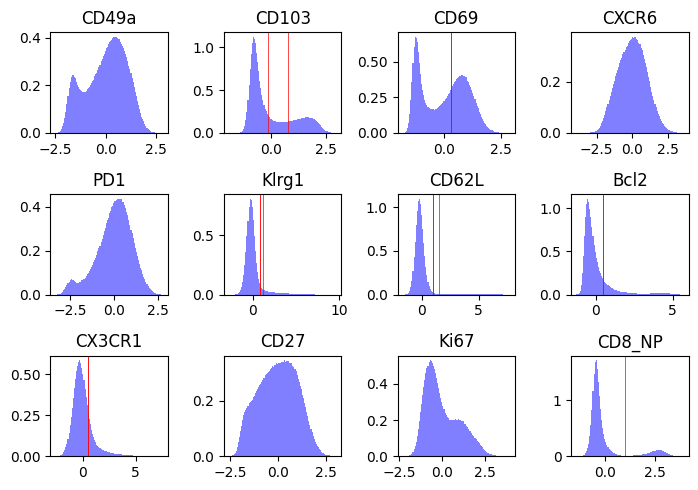

In [4]:
thresholds = {
    "Tet+" : {
        "CD8_NP" : (1.0, np.inf)
    },
    "Eff" : {
        "Klrg1" : (1.2, np.inf)
    },
    "CM" : {
        "CD62L" : (1.5, np.inf),
    },
    "TRM_SP" : {
        "CD62L" : (-np.inf, 1.0),
        "Klrg1" : (-np.inf, 0.8),
        "CD69" : (0.3, np.inf),
        "CD103" : (-np.inf, -0.1),
        "Bcl2" : (-np.inf, 0.5),
        "CX3CR1" : (-np.inf, 0.5),
    },
    "TRM_DP" : {
        "CD62L" : (-np.inf, 1.0),
        "Klrg1" : (-np.inf, 0.8),
        "CD69" : (0.3, np.inf),
        "CD103" : (0.8, np.inf),
        "Bcl2" : (-np.inf, 0.5),
        "CX3CR1" : (-np.inf, 0.5),
    }
}

# plot marginal distributions

fig, axs = plt.subplots(3, 4, figsize=(7, 5))

for i, m in enumerate(sel_markers_ext):
    X = scanpy.get.obs_df(ann_data, m)
    ax = axs.flatten()[i]
    ax.hist(X, 100, color='b', alpha=0.5, density=True)
    ax.set_title(m)
    for ph, gates in thresholds.items():
        if m in gates:
            l, u = gates[m]
            if not np.isinf(l):
                ax.axvline(x=l, color='r', linewidth=0.5)
            if not np.isinf(u):
                ax.axvline(x=u, color='r', linewidth=0.5)
    
fig.tight_layout()

for i, ax in enumerate(axs.flatten()):
    if i >= len(sel_markers_ext):
        ax.axis("off")

### Mark cells in certain gates

using the thresholds defined above

In [5]:
phenotyped_cells = {}
for ph, gates in thresholds.items():
    vals_in_gates = None
    for m, (l, u) in gates.items():
        midx = sel_markers_ext.index(m)
        vals = ann_data.obsm["X_selected_ext"][:,midx]
        vals_in_gate = ((vals > l) & (vals < u))
        if vals_in_gates is None:
            vals_in_gates = vals_in_gate
        else:
            vals_in_gates = (vals_in_gates & vals_in_gate)
        phenotyped_cells[ph] = list(vals_in_gates)

### Export the selected dataset for use in the VAE model

The same dataset will be used for the SA and the IA (intergated approach).
We create a dataset with just the flow data, and one with metadata for each cell

In [6]:
adata_copy = ann_data.obsm["X_selected_ext"].copy()

# flow data

np.savetxt(
    f"../data/pyro-dataset-CD8-Lung-Aug23.csv", 
    adata_copy, 
    delimiter=",",
    header=",".join(sel_markers_ext),
    comments='' ## no comment chars in header, PLEASE
)

# meta data

batch_id = ann_data.obs["mouse"].to_numpy()
sample_day = ann_data.obs["dpi"].to_numpy()
metadata_array = np.array([batch_id, sample_day]).T
phenotypes = sorted(list(phenotyped_cells.keys()))
phenotypes_array = np.array([[1 if x else 0 for x in phenotyped_cells[ph]] for ph in phenotypes]).T

with open(f"../data/pyro-dataset-meta-CD8-Lung-Aug23.csv", 'w') as f:
    header = "batch,day," + ",".join(phenotypes)
    f.write(header)
    for row1, row2 in zip(metadata_array, phenotypes_array):
        f.write('\n' + ','.join(map(str, np.concatenate([row1, row2]))))


### Write data to HPC and do repeated clustering

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    This step can be skipped if you want to use the pre-computed clusterings and UMAPs. 
</div>

I'm making use of `slurm` to run batch jobs.
For this, I write the data to a shared folder (called `mesh_directory`)

We also make a file containing 20 random seeds, a bash script, and a python script.
The bash script starts the python script `clus.py`

In order for this to work, the `scdynsys` package has to be installed 
in the `mesh_directory` in the virtual environment `venv`.
You also have to create `output` and `results` directory in the `mesh_directory`
that will contain script output messages (and error messages), and the cluster results,
respectively.

The bash script (slurm script) has some slurm-specific settings that will be 
dependent on your system. On my HPC, I have a "partition" called "rogue"
for such jobs. Change this to whatever you're using.

Finally, we start the batch job with `sbatch` (now commented out)

#### Important settings:

notice that we choose a KNN parameter of 10 (10 neighbors) and an intensity parameter of 0.8.
With 0.8 we appear to be somewhat over-clustering the data, but we resolve this with manual annotation.

<div class="alert alert-block alert-warning"> <b>WARNING</b> 
    Leiden clustering and UMAP takes a lot of time!
</div>

In [ ]:
mesh_directory = "/path/to/mesh/directory" ## system dependent
slurm_partition = "my_fav_partition" ## system dependent

## save data on mesh
sel_data = ann_data.obsm["X_selected"].copy()

with open(os.path.join(mesh_directory, "data.pkl"), 'wb') as f:
    pickle.dump(sel_data, f)

## a list of seeds for the PRNG used by scanpy
seeds = [
    3453, 101351, 66840, 128120, 87868,
    76628, 46369, 84567, 67626, 102967,
    24297, 135352, 118727, 91864, 34592,
    74244, 32050, 91027, 27811, 14829
]

with open(os.path.join(mesh_directory, "seeds.txt"), 'w') as f:
    f.write('\n'.join(map(str, seeds)))

bash_script = f"""\
#!/bin/bash

#SBATCH --output={mesh_directory}/output/clus.%A_%a.out
#SBATCH --error={mesh_directory}/output/clus.%A_%a.err
#SBATCH --job-name cluster
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=25
#SBATCH --array=0-19
#SBATCH --partition={slurm_partition}

cd {mesh_directory}
source venv/bin/activate

readarray -t seeds < seeds.txt
seed=${{seeds[$SLURM_ARRAY_TASK_ID]}}

python clus.py $seed
"""

with open(os.path.join(mesh_directory, "clus.sh"), 'w') as f:
    f.write(bash_script)

py_script = """\
from scdynsys.clus import leiden_clus
import pickle
import sys

seed = int(sys.argv[1])

with open("data.pkl", 'rb') as f:
    X = pickle.load(f)
    
clusters = leiden_clus(X, 10, 0.8, seed, scale=True, umap=True)

with open(f"results/clusters_CD8_0p8_{seed}.pkl", 'wb') as f:
    pickle.dump(clusters, f)
"""

with open(os.path.join(mesh_directory, "clus.py"), 'w') as f:
    f.write(py_script)

## UNCOMMENT FOR RUNNING THE SLURM JOB
    
#!sbatch -D {mesh_directory} clus.sh

### Wait for the cluster runs to finish and import the results

First import all results from the Leiden clustering runs.

In [ ]:
# import results of jobs submitted to slurm

filenames = [os.path.join(mesh_directory, f"results/clusters_CD8_0p8_{seed}.pkl") for seed in seeds]

results = []
for filename in filenames:
    with open(filename, 'rb') as f:
        results.append(pickle.load(f))

### Import pre-computed cluster and umap data

and make sure that the data is in the same format as before...

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    If you skipped the clustering and UMAPing steps above, proceed with the next cell to load a pre-computed dataset
</div>

In [7]:
clus_df = pd.read_hdf("../data/leiden_clus_assignments_CD8.hdf5")
umap_df = pd.read_hdf("../data/umap_coords_CD8.hdf5")

## The code below expects a list called results, with tuples of cluster assingments and umap coords

seeds = list(clus_df.columns)
results = []
for seed in seeds:
    clus_assign = clus_df[seed].to_numpy()
    xy = [f"x_{seed}", f"y_{seed}"]
    umap_coords = umap_df[xy].to_numpy()
    results.append((clus_assign, umap_coords))

### Visualize the 20 different clusterings and UMAPs

Make a PDF with all the inidividual cluster runs. These can then be used for manual annotation.
The PDFs contain a UMAP in which the clusters are identied with colors and numbers,
and a heatmap showing mean marker expression per cluster

In [8]:
# plot umap with clusters and heatmap for each seed for manual phenotyping

from matplotlib.backends.backend_pdf import PdfPages

def umap_cluster_plot(ax, zs, cs, clus, colors):
    means = utils.get_mean_per_cluster(zs, cs, label_order=clus)    
    for i, cl in enumerate(clus):
        sel = cs == cl
        cc = colors[i]
        ax.scatter(*zs[sel].T, s=1, linewidths=0, color=cc, alpha=0.3, rasterized=True)
        xi, yi = means[i]
        ax.text(xi, yi, cl, va='center', ha='center', bbox = dict(boxstyle="circle", color=cc))
    
    # remove x and y ticks and set labels
    [f([]) for f in [ax.set_xticks, ax.set_yticks]]
    [f(f"UMAP {i+1}") for i, f in enumerate([ax.set_xlabel, ax.set_ylabel])]
        
def heatmap_cluster_plot(ax, xs, cs, feat, clus, colors):   
    MFI = utils.get_mean_per_cluster(
        xs, cs, label_order=clus
    )
    MFI = sts.zscore(MFI, axis=0)
    plots.simple_heatmap(ax, MFI, feat, clus)
    
    for i, tick in enumerate(ax.get_yticklabels()):
        tick.set_color(colors[i])

        
with PdfPages("../results/leiden_clusterings_CD8_0p8.pdf") as pdf:
    for seed, res in zip(seeds, results):
        fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
        
        # unpack the result: clustering and umap
        cl, um = res

        # sort clusters by size
        clus_sizes = Counter(cl)
        clus = sorted(list(clus_sizes.keys()), key=lambda x : clus_sizes[x], reverse=True)

        umap_cluster_plot(axs[0], um, cl, clus, tabcolors)

        ord_markers = ["CD69", "CD103", "CD49a", "CXCR6", "CD27", "CD62L", "Bcl2", "Klrg1", "PD1", "CX3CR1"]
        marker_idxs = [sel_markers.index(m) for m in ord_markers]

        xs = ann_data.obsm["X_selected"]
        heatmap_cluster_plot(axs[1], xs[:, marker_idxs], cl, ord_markers, clus, tabcolors)
        
        axs[0].set_title(f"UMAP embedding for seed {seed}")
        axs[1].set_title(f"MFI for seed {seed}")
    
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        plt.close(fig)

### Combine the clusterings into a simple data frame

Which could be shared online. The writing to hdf5 files is current commented out.

In [9]:
# data frame with cluster assignments

clus_df = pd.DataFrame(columns=seeds)

for i, seed in enumerate(seeds):
    clus_df[seed] = results[i][0]

# data frame with UMAP coordinates

cols = [c for s in seeds for c in [f"x_{s}", f"y_{s}"]]

umap_df = pd.DataFrame(columns=cols)

for i, s in enumerate(seeds):
    for j, z in enumerate(["x", "y"]):
        zcoords = results[i][1][:,j]
        col = f"{z}_{s}"
        umap_df[col] = zcoords

## UNCOMMENT TO SAVE THE DATAFRAMES

#clus_df.to_hdf("../data/leiden_clus_assignments_CD8.hdf5", key="df", mode='w')
#umap_df.to_hdf("../data/umap_coords_CD8.hdf5", key='df', mode='w')

### Manually annotate Leiden clusters into cell types

This is a tedious process, especially if you have to do it 20 times.
Hopefully repeating this manual annotation 20 times reduces the chance of 
incorrect annotations. The annotations used for our analysis are given in the
JSON file `leiden_cluster_annotation_CD8.json` in the `data` folder.

For each seed, we map each Leiden cluster to a cell type.
The cell types we identified were

* **103 SP TRM**: CD103+ CD69- Resident Memory T cells
* **69 SP TRM**: CD60+ CD103- Resident Memory T cells
* **CX3CR1hi TEM**: CX3CR1+ Effector Memory T cells
* **DN TRM**: CD103- CD69- "double negative" Resident Memory T cells
* **DP TRM**: CD103+ CD69+ "double positive" Resident Memory T cells
* **Eff**: Effector T cells
* **TCM**: Central Memory T cells
* **TEM**: Effector Memory T cells (CX3CR1-)

#### Next, make a histogram of how many times each population occurs

Some populations are not called in each cluster run. For instance DN TRM

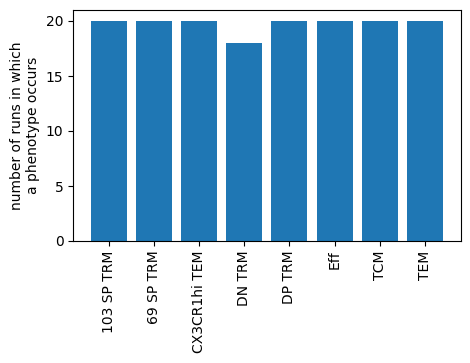

In [10]:
with open("../data/leiden_cluster_annotation_CD8.json", 'r') as f:
    cluster_dicts = json.load(f)

# convert keys (which are string in JSON) to int (seeds and Leiden cluster IDs)

cluster_dicts = {
    int(s) : {int(c) : v1 for c, v1 in v2.items()}
    for s, v2 in cluster_dicts.items()
}

# make a histogram to check if annotation has any issues.

all_phenotypes = sorted(utils.unique([x for cd in cluster_dicts.values() for x in cd.values()]))

occurences = [sum([v in cd.values() for cd in cluster_dicts.values()]) for v in all_phenotypes]

fig, ax = plt.subplots(1, 1, figsize=(5,3))

ticks = range(len(occurences)) 
ax.bar(ticks, occurences)
ax.set_xticks(ticks)
ax.set_xticklabels(all_phenotypes, rotation=90)
ax.set_ylabel("number of runs in which\na phenotype occurs");

### For each event, compute probability of cluster membership

This will show how certain we are about cluster assignments and the level of ambiguity that comes from the stochastic Leiden algo.

In [11]:
cell_type_names = ["DP TRM", "69 SP TRM", "103 SP TRM", "DN TRM", "TEM", "CX3CR1hi TEM", "TCM", "Eff"]

num_samples = results[0][0].shape[0]
cell_type_assignments = np.zeros((num_samples, len(cell_type_names)))

for res, seed in zip(results, seeds):
    cluster_assignments = res[0]
    for i, c in enumerate(cluster_assignments):
        ct = cluster_dicts[seed].get(int(c))
        if ct is not None:
            j = cell_type_names.index(ct)
            cell_type_assignments[i,j] += 1

#### Show entropy in a UMAP plot

also show the clusters in a UMAP and the entropy distribution per cluster. Which clusters are more unambigously defined?

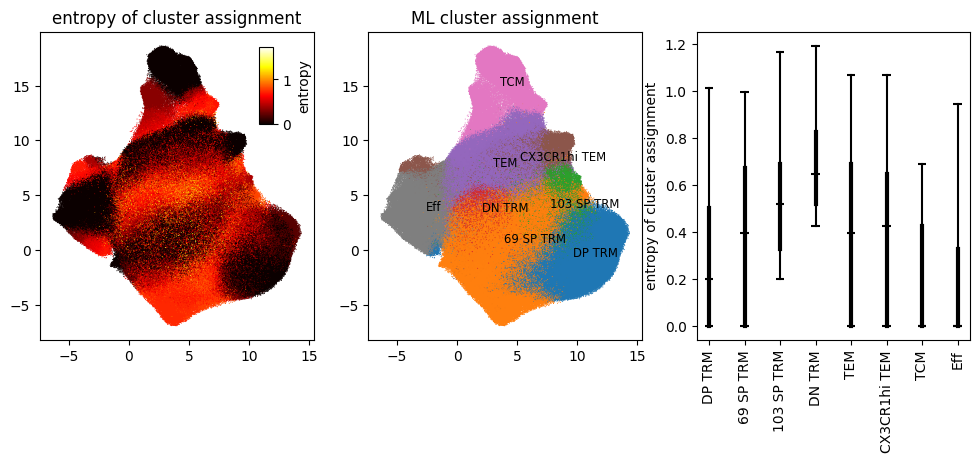

In [12]:
# normalize cell type assignments
cell_type_probs = cell_type_assignments / np.sum(cell_type_assignments, axis=1, keepdims=True)

# compute entropy
cell_type_entropy = sts.entropy(cell_type_probs.T)

# plot entropy in a umap
selected_umap = seeds.index(27811) # choose one of the seeds for a "nice" UMAP
umap_embedding = results[selected_umap][1]

fig, axs = plt.subplots(1, 3, figsize=(12,4))

## plot the entropy of cell type assignment for each cell
ax = axs[0]
max_H = sts.entropy(np.ones(len(cell_type_names)))
cs = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=cell_type_entropy, s=0.5, linewidths=0, cmap='hot')
ins_ax = ax.inset_axes([0.8, 0.7, 0.05, 0.25], transform=ax.transAxes)
cx = fig.colorbar(cs, cax=ins_ax)
cx.set_label("entropy")
ax.set_title("entropy of cluster assignment")


## plot the most likely cell type assignment (based on 20 manual annotations)
ML_cell_type = np.argmax(cell_type_probs, axis=1)

ct_colors = [tabcolors[i] for i in ML_cell_type]

ax = axs[1]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=ct_colors, s=0.5, linewidths=0)
ax.set_title("ML cluster assignment")

means = utils.get_mean_per_cluster(umap_embedding, ML_cell_type)
for ct, m in zip(cell_type_names, means):
    ax.text(*m, ct, fontsize='small')

## plot distribution of entropy for each cluster

ax = axs[2]
ct_idxs = sorted(list(set(ML_cell_type)))
hs_per_clus = []
for i in ct_idxs:
    h = cell_type_entropy[ML_cell_type == i]
    hs_per_clus.append(h)
    
plots.fancy_boxplot(ax, hs_per_clus)
ax.set_xticks(ct_idxs)
ax.set_xticklabels(cell_type_names, rotation=90)
ax.set_ylabel("entropy of cluster assignment");

## Compute "differential abundance" (DA)

This assumes that `cell_type` annotations have been added to the `ann_data` object

The goal is to create timeseries of relative cluster sizes based on the time since infection for each of the mice. This way, we condense the large flow dataset into a much more compact multi-dimensional timeseries.

We make use of a function `compute_DA_matrix` defined in the `utils` module

In [13]:
## add ML cluster assignment to the data frame

ann_data.obs['cell_type'] = [cell_type_names[i] for i in ML_cell_type]

## make sure that the time points and freq data correspond!

sorted_mice = sorted(mice, key=lambda x: (day_dict[x], int(x)))

count_df = utils.compute_DA_matrix(ann_data.obs['cell_type'], ann_data.obs["mouse"])
num_cell_types = len(count_df.index)

sorted_mice_str = [str(x) for x in sorted_mice]

display(count_df[sorted_mice_str])

,9,10,11,12,13,14,15,16,18,20,...,30,31,34,36,37,38,39,40,41,42
69 SP TRM,34218,43324,76738,68297,10565,11095,20251,18336,2998,3649,...,1911,875,1280,314,888,547,555,680,603,451
DP TRM,10132,7558,9797,17470,18410,20975,27466,43627,8852,13627,...,3056,1850,1386,385,833,591,519,627,642,442
TEM,18980,25064,38491,35797,5814,8175,13330,8751,1761,2230,...,722,282,869,230,307,232,235,308,253,339
DN TRM,4408,5306,19424,21622,967,2184,4111,2548,65,102,...,9,6,1,2,2,1,0,4,3,0
Eff,7264,11515,16097,14102,1578,1694,2458,3282,241,355,...,76,37,95,76,30,6,61,13,22,34
103 SP TRM,4647,3525,4173,6676,2506,5305,9719,7448,436,1171,...,126,57,68,60,83,69,61,117,73,54
TCM,3656,5041,9880,8146,1659,1494,3729,1559,490,856,...,178,120,602,151,86,94,117,180,204,158
CX3CR1hi TEM,3791,3158,4790,5382,1844,3148,8253,4487,583,509,...,76,40,68,46,57,12,21,20,26,42


### Compute the MFI per T cell population

Plot the MFI matrix

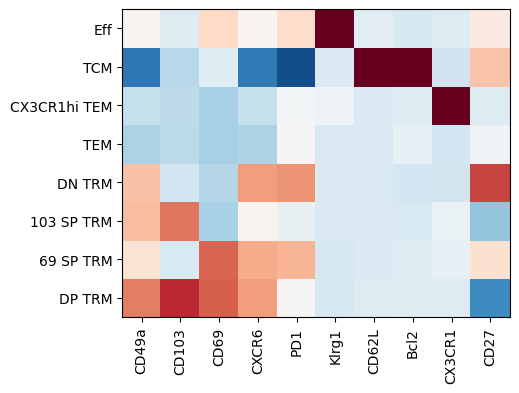

In [14]:
celltype_per_sample = ann_data.obs["cell_type"].to_numpy()

MFI = utils.get_mean_per_cluster(
    ann_data.obsm["X_selected"], 
    celltype_per_sample,
    label_order=cell_type_names
)
MFI = sts.zscore(MFI, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
plots.simple_heatmap(ax, MFI, sel_markers, cell_type_names)

### Use sampling days of each mouse to construct time series

We can replace the mouse ID with a DPI to create a timeseries,
showing how the T cell subset composition changes post infection.

Together with the total number of T cells in the lung, these timeseries are used to fit Stan models in the next notebook

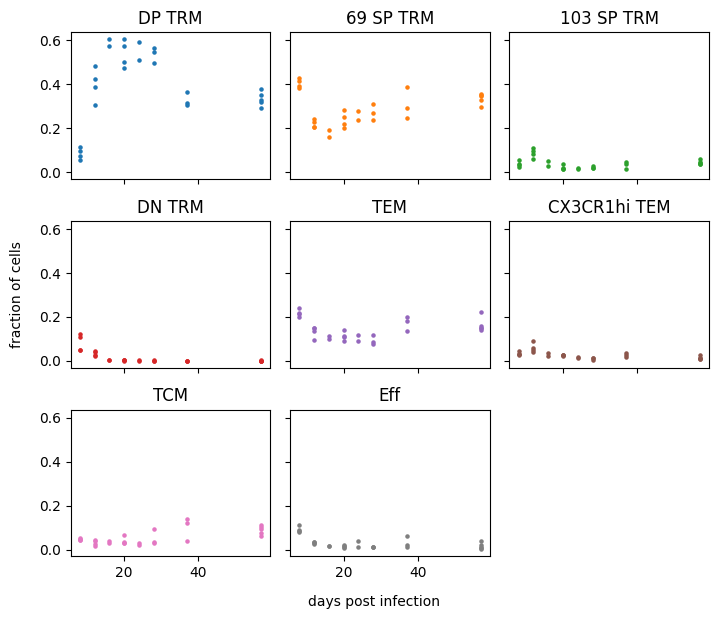

In [15]:
## compute and plot cluster frequencies

fig, axs = plt.subplots(3, 3, figsize=(7,6), sharey=True, sharex=True)

# make sure that cell types have consistent colors
celltype_color_dict = dict(zip(cell_type_names, tabcolors))

freq_df = count_df / count_df.sum(axis=0)

for i, ax in enumerate(axs.flatten()):
    if i >= num_cell_types:
        ax.axis("off")
        continue
    cell_type = cell_type_names[i]
    days = [day_dict[m] for m in sorted_mice]
    qs = freq_df[sorted_mice_str].loc[cell_type]
    col = celltype_color_dict[cell_type]
    ax.scatter(days, qs, s=5, c=col)
    ax.set_title(f"{cell_type}")

fig.text(0.5, 0.0, "days post infection", va='top', ha='center')
fig.text(0.0, 0.5, "fraction of cells", va='center', ha='right', rotation=90)
fig.tight_layout()

### Show where the Tet+ cells are located in the UMAP

In what sense are the clusters defined using "bulk" T cells also valid for Tetramer+ cells?
Make a UMAP showing the cluster boundaries, and indicate the density of Tet+ cells

<div class="alert alert-block alert-warning"> <b>WARNING</b> 
    This is a bit slow, probably because we're computing a Gaussian KDE for many cells
</div>


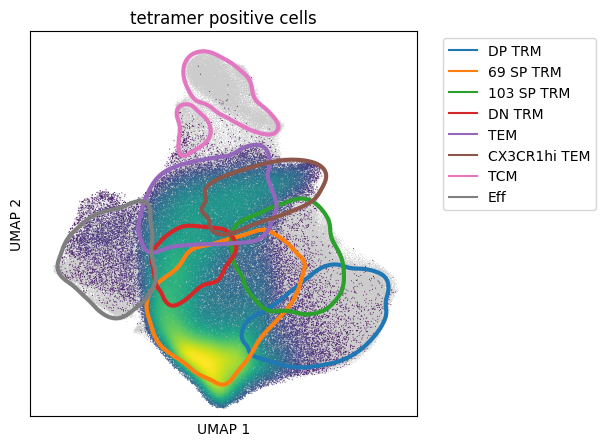

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c='0.8', s=0.1, rasterized=True, linewidths=0)
tetpos = phenotyped_cells["Tet+"]
tet_dens = sts.gaussian_kde(umap_embedding[tetpos,:].T)(umap_embedding[tetpos,:].T)
ax.scatter(umap_embedding[tetpos,0], umap_embedding[tetpos,1], c=tet_dens, s=0.5, rasterized=True, linewidths=0)

patches = []
for i, ct in enumerate(cell_type_names):
    col = celltype_color_dict[ct]
    idxs = [i for i, c in enumerate(celltype_per_sample) if c == ct]
    X = umap_embedding[idxs, :]
    ran_idxs = np.random.choice(X.shape[0], 1000)
    patch = plots.plot_hpd_contour(ax, X[ran_idxs,:], linewidth=3, color=col, label=ct)
    patches.append(patch)

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1.0))
    
ax.set_title("tetramer positive cells")

ax.set(xlabel="UMAP 1", ylabel="UMAP 2", xticks=[], yticks=[]);

### Export data for SA data processing figure

Using the above data, we will generate an overview figure for the manuscript in a separate notebook.
For this figure, we need:

* UMAP coordinates
* celltype assignments
* MFI
* mouse ID per sample
* day per mouse
* frequency data frame per mouse and celltype
* entropy (Suppl. Fig)
* tetramer positive cells
* density of tetramer positive cells

In [17]:
seq_data_dict = {}

seq_data_dict["umap_coords"] = umap_embedding
seq_data_dict["celltypes"] = celltype_per_sample
seq_data_dict["celltype_names"] = cell_type_names
seq_data_dict["MFI"] = MFI
seq_data_dict["markers"] = sel_markers
seq_data_dict["count_df"] = count_df
seq_data_dict["freq_df"] = freq_df
seq_data_dict["mouse_day_dict"] = day_dict
seq_data_dict["batch_id"] = batch_id
seq_data_dict["sample_day"] = sample_day
seq_data_dict["entropy"] = cell_type_entropy
seq_data_dict["umap_coords_tetpos"] = umap_embedding[tetpos,:]
seq_data_dict["tet_dens"] = tet_dens


with open("../results/data_SA_clustering.pkl", "wb") as f:
    pickle.dump(seq_data_dict, f)